# OPENCLASSROOMS - Parcous Data Scientiest

# Projet 8 - Déployez un modèle dans le cloud

## 1- Importation des librairies

In [1]:
#Importation des librairies

#Librairies de manipulation des données
import pandas as pd
from PIL import Image
import numpy as np
from time import perf_counter

#Librairies gestion système
import io
import os

#Visualisation des données
import matplotlib.pyplot as plt
%matplot plt

#Manipulation des données via pyspark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

#Modules tensorflow d'extraction des features
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

#Importation du module pandas de pyspark
from pyspark import pandas as pd2

#Gestion des tyês de données pyspark
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import StructType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import array_to_vector
from pyspark.ml.functions import vector_to_array

#Importation de la PCA pyspark
from pyspark.ml.feature import PCA

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1682462009535_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2- Mise en place de la session Spark et définition des accès au bucket S3

In [2]:
#Création du driver et du sparkcontext permettant d'attribuer les différentes tâches à nos executeurs

spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

sc = spark.sparkContext

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Chemins d'accès vers les données, le stockage des résultats et l'enregistrement des poids du modèle

PATH = 's3://oc-ds8-ye-data-eu'
PATH_Data_Test = PATH+'/Test'
PATH_Data_Train = PATH+'/Train'
PATH_Result_Test = PATH+'/Results_Test'
PATH_Result_Train = PATH+'/Results_Train'
PATH_PCA_Results_Test = PATH +'/PCA_Results_Test'
PATH_PCA_Results_Train = PATH +'/PCA_Results_Train'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#Importation des images (stockage du chemin d'accès de chaque image du bucket s3)

images_test = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data_Test)

images_train = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data_Train)

images_test = images_test.withColumn('label', element_at(split(images_test['path'], '/'),-2))
images_train = images_train.withColumn('label', element_at(split(images_train['path'], '/'),-2))

print(images_test.printSchema())
print(images_test.select('path','label').show(5,False))
print(images_train.printSchema())
print(images_train.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------+----------+
|path                                                |label     |
+----------------------------------------------------+----------+
|s3://oc-ds8-ye-data-eu/Test/Watermelon/r_106_100.jpg|Watermelon|
|s3://oc-ds8-ye-data-eu/Test/Watermelon/r_109_100.jpg|Watermelon|
|s3://oc-ds8-ye-data-eu/Test/Watermelon/r_108_100.jpg|Watermelon|
|s3://oc-ds8-ye-data-eu/Test/Watermelon/r_107_100.jpg|Watermelon|
|s3://oc-ds8-ye-data-eu/Test/Watermelon/r_95_100.jpg |Watermelon|
+----------------------------------------------------+----------+
only showing top 5 rows

None
root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

In [5]:
#Affichage de 5 lignes du dataframe images_test

images_test.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+----------+
|                path|   modificationTime|length|             content|     label|
+--------------------+-------------------+------+--------------------+----------+
|s3://oc-ds8-ye-da...|2023-04-07 17:21:39|  7353|[FF D8 FF E0 00 1...|Watermelon|
|s3://oc-ds8-ye-da...|2023-04-07 17:21:39|  7350|[FF D8 FF E0 00 1...|Watermelon|
|s3://oc-ds8-ye-da...|2023-04-07 17:21:39|  7349|[FF D8 FF E0 00 1...|Watermelon|
|s3://oc-ds8-ye-da...|2023-04-07 17:21:39|  7348|[FF D8 FF E0 00 1...|Watermelon|
|s3://oc-ds8-ye-da...|2023-04-07 17:21:40|  7328|[FF D8 FF E0 00 1...|Watermelon|
+--------------------+-------------------+------+--------------------+----------+
only showing top 5 rows

In [6]:
#Création du feature extractor et broadcast des poids du modèle (poids imagenet)

model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

#De manière à obtenir une sortie de forme (1, 1280), nous conservons le modèle jusqu'à la couche de GlobalAvergaePooling

new_model = tf.keras.Model(inputs=model.input,
                  outputs=model.layers[-2].output)
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
#Affichage de l'architecture du modèle 

new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

## 3- Extraction des features des images

In [8]:
#Fonction de construction du modèle à partir des poids imagenet distribuées aux exécuteurs

def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1682462009535_0003/container_1682462009535_0003_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

In [10]:
#Extraction des features des images et enregistrement sur le bucket s3 dans le repértoire Results

features_df_train = images_train.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

features_df_test = images_test.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
#Ecriture des features dans le bucket s3 par chaque worker pour le jeu de données Train
features_df_train.write.mode("overwrite").parquet(PATH_Result_Train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
#Ecriture des features dans le bucket s3 par chaque worker pour le jeu de données Test
features_df_test.write.mode("overwrite").parquet(PATH_Result_Test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
#Lecture des features extraits du jeu de données de Train sous forme d'un dataframe pandas

extracted_features_df = pd2.read_parquet(PATH_Result_Train)
print("Liste des colonnes : {}".format(extracted_features_df.columns.tolist()))
print("Forme du DataFrame : {}".format(extracted_features_df.shape))
print("Decompte des valeurs manquantes : {}".format(extracted_features_df.isna().sum().sum()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Liste des colonnes : ['path', 'label', 'features']
Forme du DataFrame : (67692, 3)
Decompte des valeurs manquantes : 0

## 4- Visualisation des Features extraits

In [14]:
#Fonction d'affichage des 10 premiers features d'une image

def random_features_displayer():
    #Séléction aléatoire d'un individu
    n = np.random.randint(len(extracted_features_df.index))
    obs_index = extracted_features_df.index.tolist()[n]
    tmp_df = extracted_features_df.iloc[obs_index]
    print("\033[1mIndividu index\033[0;0m : {}".format(obs_index))
    print("\033[1mChemin d'acces de l'image initiale \033[0;0m: {}".format(tmp_df['path']))
    print("\033[1mLabel de l'image initiale \033[0;0m: {}".format(tmp_df['label']))
    print("\n")
    for i in range(10):
        tmp = str(tmp_df['features'][i])[:10]
        print("\033[1mFeature {} \033[0;0m: {}".format(i, tmp))
    #return tmp_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
#Essai de la fonction

random_features_displayer()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Individu index : 63261
Chemin d'acces de l'image initiale : s3://oc-ds8-ye-data-eu/Train/Huckleberry/267_100.jpg
Label de l'image initiale : Huckleberry


Feature 0 : 0.38292208
Feature 1 : 0.34610891
Feature 2 : 0.69838303
Feature 3 : 0.0
Feature 4 : 1.79068362
Feature 5 : 0.0
Feature 6 : 0.18838687
Feature 7 : 0.17401410
Feature 8 : 0.00635343
Feature 9 : 0.0

In [20]:
#Fonction permettant d'afficher la distribution d'un feature extrait dans notre jeu de données

def feature_distribution_displayer(df, feature: int):
    #Calcul du nombre de features maximal accépté
    n_features = len(df['features'][0])
    
    #Vérification de l'index maximal entré par l'utilisateur - erreur si supérieur à n_features -1
    try:
        assert feature < n_features - 1
    except:
        raise Exception("Veuillez entrer un feature d'index inferieur à {}".format(n_features)) 
    
    #Récupération de la valeur du feature demandé pour chaque individu
    tmp_series = df['features'].apply(lambda x : x[feature])
    
    #Dictionnaire associant les noms des indicateurs statistiques des distributions à leurs valeurs
    indic_dict = {"Moyenne" : tmp_series.mean(), "Mediane" : tmp_series.median() \
                  , "Deviation Standard" : tmp_series.std(), "Skewness" : tmp_series.skew(), \
                  "Kurtosis" : tmp_series.kurt()}
    
    #Affichage de la distribution
    plt.rcParams.update({'font.size' : 12})
    plt.figure(figsize = (10,6))
    plt.title("Distribution de la variable extraite numero {}".format(feature), size = 20, weight = 'bold')
    h = plt.hist(tmp_series.values, bins = 100, label = "Distribution des {} individus".format(len(df)))
    plt.ylabel('Decompte des individus', size = 15, weight = 'bold')
    plt.xlabel('Valeurs du feature {}'.format(feature), size = 15, weight = 'bold')
    plt.yscale('log')
    plt.grid(True, ls = '--')
    
    #Valeur maximales des axes x et y
    max_y = np.max(h[0])
    max_x = np.max(h[1])
    
    #Boucle sur les valeurs des différents indicateurs statistiques claassiques de la distribution et affichage
    for (pos, cle), color in zip(enumerate(indic_dict), ['red', 'green', 'orange', 'purple', 'cyan']):
        valeur = indic_dict[cle]
        plt.plot(np.full(len(df), valeur), np.linspace(0, max_y, len(df)), 
                 color = color, label = "{} : {}".format(cle, str(valeur)[:4]), ls = '--', lw = 3)
        
    #Affichage du plot final
    plt.legend(loc = 'upper right', title = 'Legend', facecolor = 'cornsilk', title_fontsize = 15, fontsize = 8)
    plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

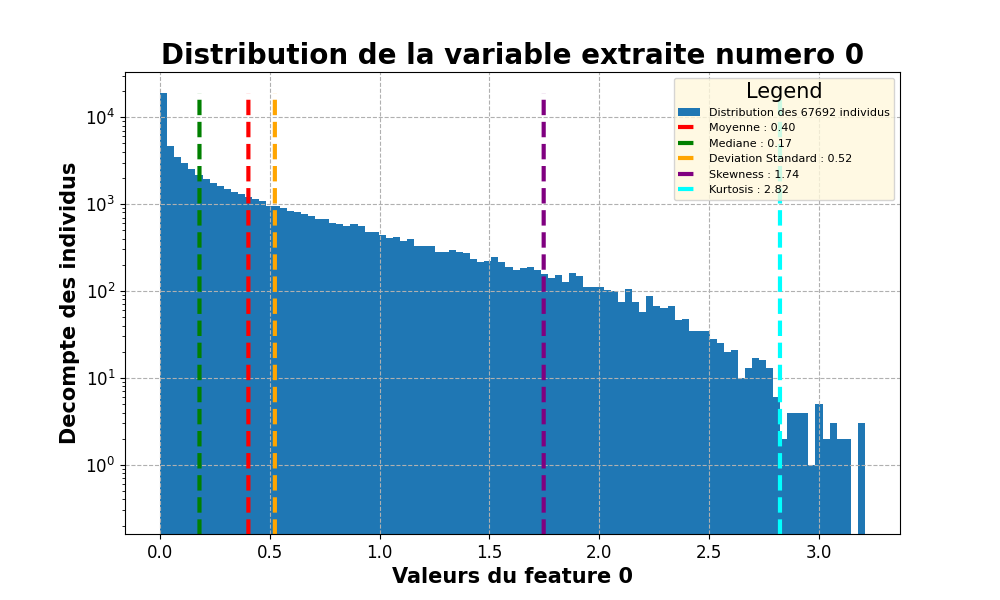

In [21]:
#Affichage de la distribution du feature numero 0

feature_distribution_displayer(extracted_features_df, 0)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

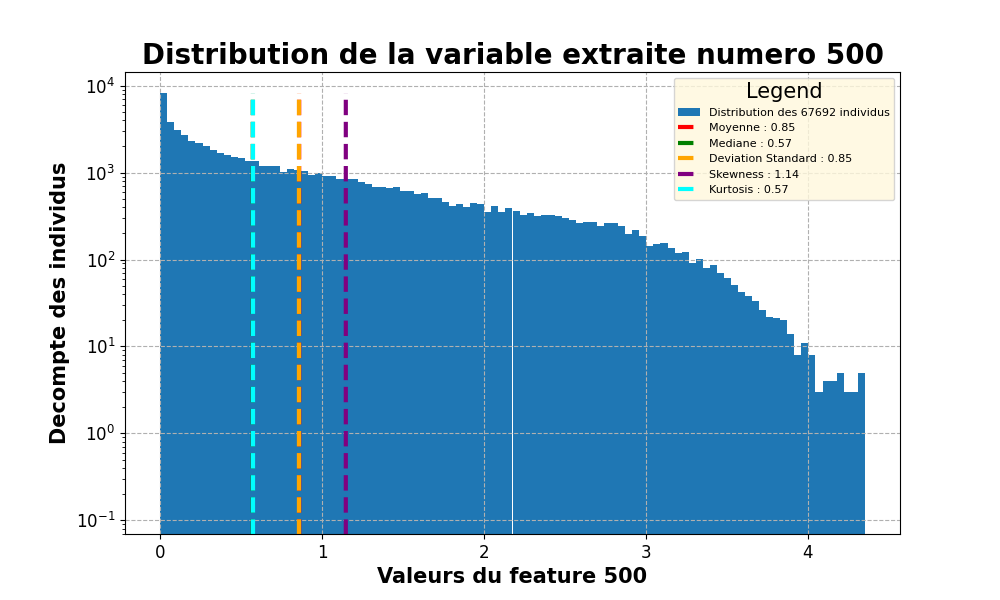

In [22]:
#Affichage de la distribution du feature numero 500

feature_distribution_displayer(extracted_features_df, 500)
%matplot plt

In [23]:
#Fonction permettant d'afficher la distribution d'un feature extrait dans notre jeu de données

def obs_distribution_displayer(df, obs: int):
    #Calcul du nombre de features maximal accépté
    n_indiv = len(df['features'])
    
    #Vérification de l'index maximal entré par l'utilisateur - errueur si supérieur à l'index maximale des observations
    try:
        assert obs < n_indiv - 1
    except:
        raise Exception("Veuillez entrer un feature d'index inferieur à {}".format(n_indiv)) 
    
    #Récupération des valeurs de chaque feature pour l'individu demandé
    tmp_series = pd2.Series(df['features'][0])
    
    #Dictionnaire associant les noms des indicateurs statistiques des distributions à leurs valeurs
    indic_dict = {"Moyenne" : tmp_series.mean(), "Mediane" : tmp_series.median() \
                  , "Deviation Standard" : tmp_series.std(), "Skewness" : tmp_series.skew(), \
                  "Kurtosis" : tmp_series.kurt()}
    
    #Affichage de la distribution
    plt.rcParams.update({'font.size' : 12})
    plt.figure(figsize = (10,6))
    plt.title("Distribution des features de l'observation {}".format(obs), size = 20, weight = 'bold')
    h = plt.hist(tmp_series.values, bins = 100, label = "Distribution des {} features".format(len(tmp_series)))
    plt.ylabel('Decompte des features', size = 15, weight = 'bold')
    plt.xlabel("Valeurs des features de l'individu {}".format(obs), size = 15, weight = 'bold')
    plt.yscale('log')
    plt.grid(True, ls = '--')
    
    #Valeur maximales des axes x et y
    max_y = np.max(h[0])
    max_x = np.max(h[1])
    
    #Boucle sur les valeurs des différents indicateurs statistiques claassiques de la distribution et affichage
    for (pos, cle), color in zip(enumerate(indic_dict), ['red', 'green', 'orange', 'purple', 'cyan']):
        valeur = indic_dict[cle]
        plt.plot(np.full(len(df), valeur), np.linspace(0, max_y, len(df)), 
                 color = color, label = "{} : {}".format(cle, str(valeur)[:4]), ls = '--', lw = 3)
        
    #Affichage du plot final
    plt.legend(loc = 'upper right', title = 'Legend', facecolor = 'cornsilk', title_fontsize = 15, fontsize = 8)
    plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

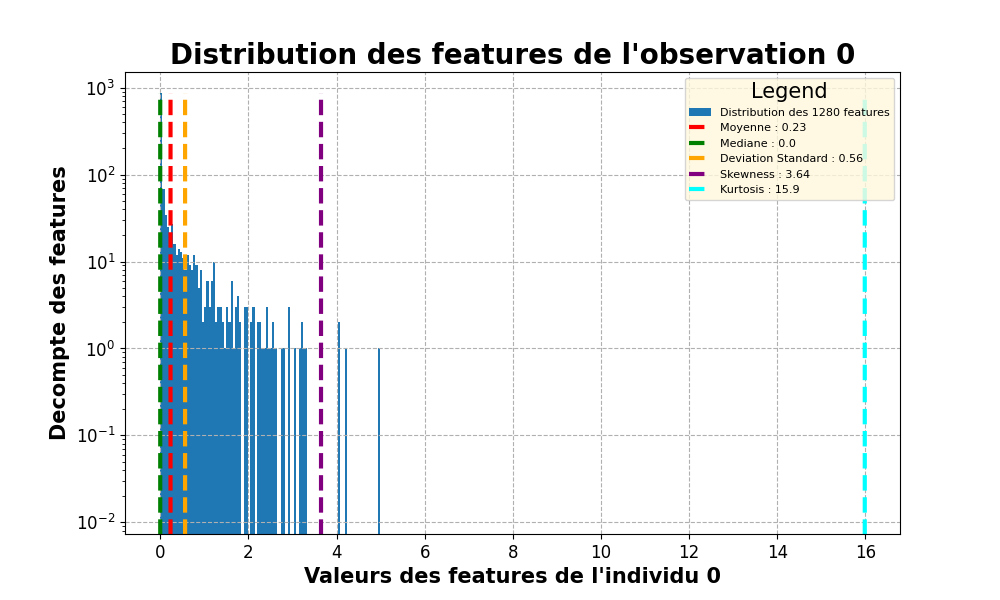

In [24]:
#Distribution des features de l'individu 0

obs_distribution_displayer(extracted_features_df, 0)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

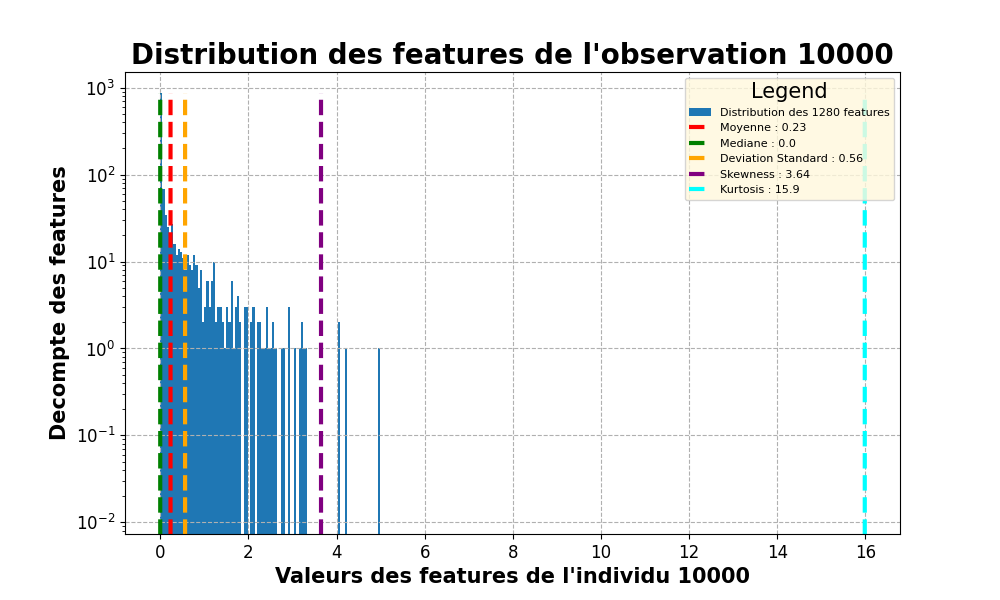

In [25]:
#Distribution des features de l'individu 10000

obs_distribution_displayer(extracted_features_df, 10000)
%matplot plt

## 5- Réduction dimentionnelle par PCA

### 5.1- Prétraitements - Variables centrées-réduites

In [26]:
#Passage des features d'un dataframe pandas à un dataframe pyspark

spark_features_df = pd2.frame.DataFrame.to_spark(extracted_features_df)
spark_features_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[path: string, label: string, features: array<float>]

In [27]:
#Création de la colonnes features_vectors de type vector compatible avec les méthodes ML pyspark

spark_features_df = spark_features_df.withColumn("features_vectors", array_to_vector("features"))
spark_features_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|    features_vectors|
+--------------------+--------------+--------------------+--------------------+
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.9820566, ...|[0.0,4.9820566177...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.06933715, 0.44...|[0.06933715194463...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.33765963, 0.27...|[0.33765962719917...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.012767685, 0.2...|[0.01276768464595...|
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.363872, 0...|[0.0,4.3638720512...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.045052707, 0.4...|[0.04505270719528...|
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.621287, 0...|[0.0,4.6212868690...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.025207894, 0.2...|[0.02520789392292...|
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 5.020222, 0...|[0.0,5.0202221870...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.

In [28]:
#Entraînement et utilisation du Standard Scaler

std = StandardScaler(inputCol = 'features_vectors', 
                     outputCol = 'features_std', 
                     withMean = True, withStd = True).fit(spark_features_df)

spark_features_df = std.transform(spark_features_df)

spark_features_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features|    features_vectors|        features_std|
+--------------------+--------------+--------------------+--------------------+--------------------+
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.9820566, ...|[0.0,4.9820566177...|[-0.7690936033439...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.06933715, 0.44...|[0.06933715194463...|[-0.6363233562448...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.33765963, 0.27...|[0.33765962719917...|[-0.1225260579331...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.012767685, 0.2...|[0.01276768464595...|[-0.7446454020870...|
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.363872, 0...|[0.0,4.3638720512...|[-0.7690936033439...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.045052707, 0.4...|[0.04505270719528...|[-0.6828244258678...|
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.621287, 0...|[0.0,4.6212868690...|[-0.76909360

### 5.2- Recherche du meilleur nombre d'axes d'inerties

In [29]:
#Initialisation de la PCA et entraînement

pca = PCA(k=1280, inputCol="features_std", outputCol = "pca_features").fit(spark_features_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

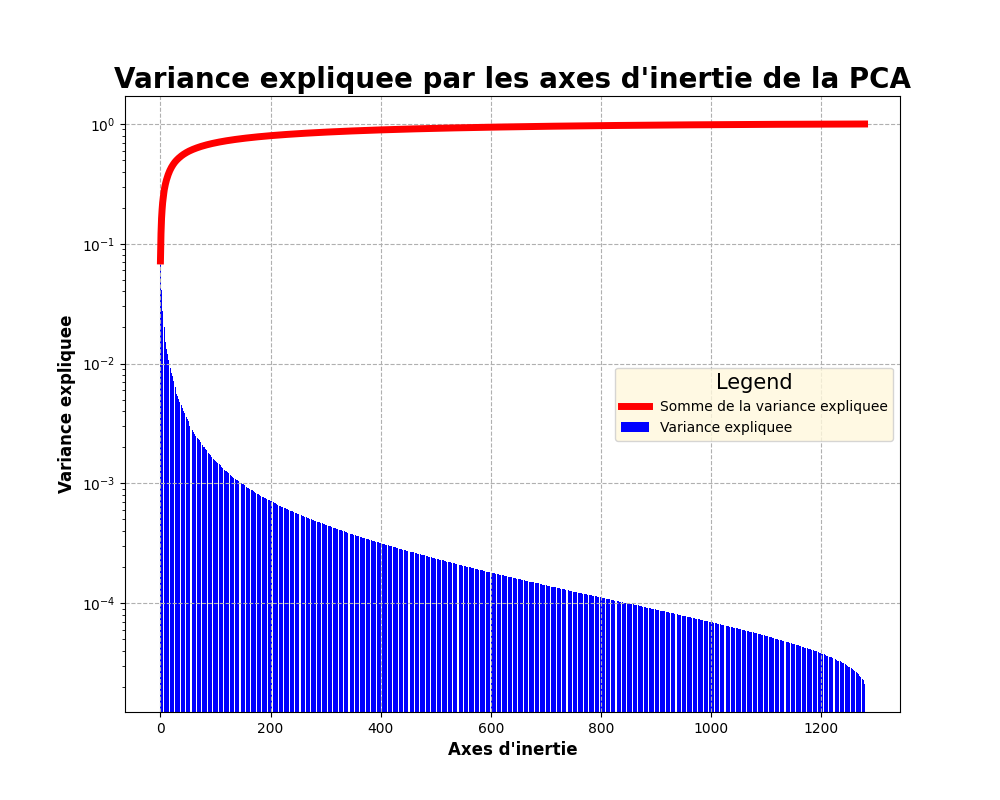

In [32]:
#Affichage de la variance expliquée cumulée par axe d'inertie

plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size' : 10})
plt.title("Variance expliquee par les axes d'inertie de la PCA", size = 20, weight = 'bold')
plt.bar(range(len(pca.explainedVariance)), pca.explainedVariance, color = 'blue', label = 'Variance expliquee')
plt.plot(range(len(pca.explainedVariance)), pca.explainedVariance.cumsum(), 
         color = 'red', label = 'Somme de la variance expliquee', lw = 5)
plt.xlabel("Axes d'inertie", size = 12, weight = 'bold')
plt.ylabel("Variance expliquee", size = 12, weight = 'bold')
plt.grid(True, ls = '--')
plt.yscale('log')
plt.legend(loc = 'right', title = 'Legend', facecolor = 'cornsilk', title_fontsize = 15)
plt.show()
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

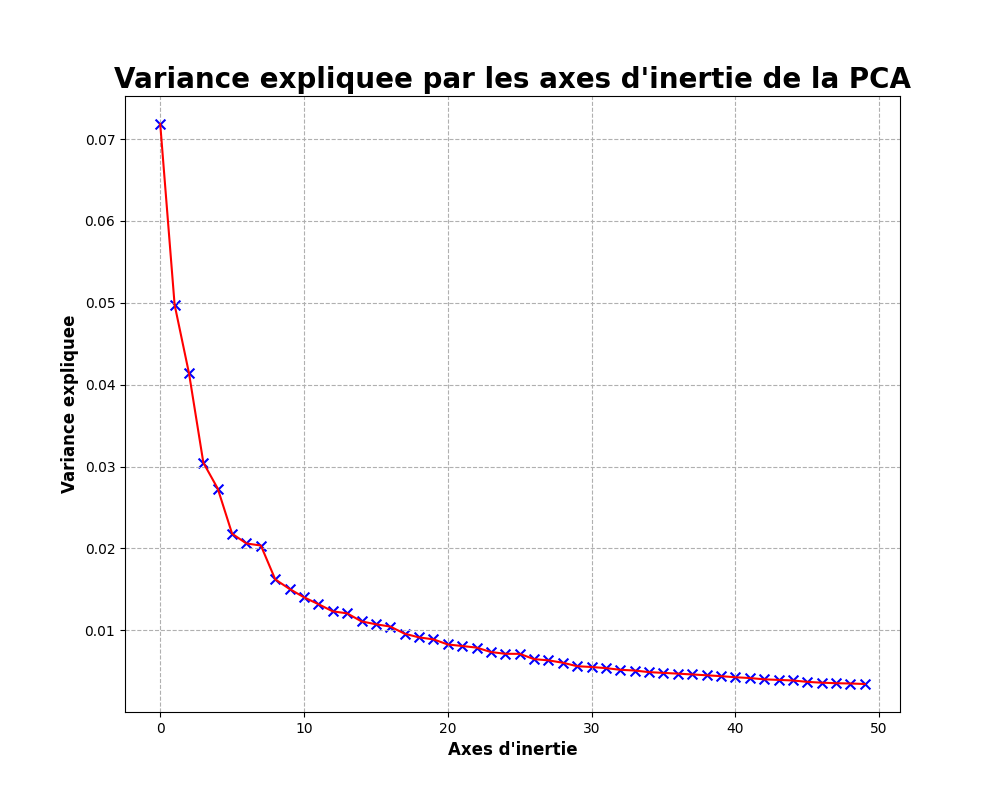

In [33]:
#Affichage de la variance expliquée cumulée pour les 50 premiers axes d'inertie

plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size' : 10})
plt.title("Variance expliquee par les axes d'inertie de la PCA", size = 20, weight = 'bold')
plt.scatter(range(len(pca.explainedVariance))[:50], pca.explainedVariance[:50], color = 'blue', 
            label = 'Variance expliquee', s = 50, marker = 'x')
plt.plot(range(len(pca.explainedVariance))[:50], pca.explainedVariance[:50], color = 'red')
plt.xlabel("Axes d'inertie", size = 12, weight = 'bold')
plt.ylabel("Variance expliquee", size = 12, weight = 'bold')
plt.grid(True, ls = '--')
plt.show()
%matplot plt

In [34]:
#Création d'un dataframe mesurant la variance expliquée cumulée

cumsumvar_rdd = sc.parallelize(pca.explainedVariance.cumsum().tolist())
cumsumvar_df = cumsumvar_rdd.map(lambda x: (x, )).toDF(["CumSumVariancy"])
cumsumvar_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|     CumSumVariancy|
+-------------------+
|0.07184251153515694|
|0.12161439822725487|
| 0.1630155475174027|
|0.19348633109479926|
| 0.2208003238898136|
|0.24259543468516312|
| 0.2632014911265256|
| 0.2835630374411282|
|0.29978150857885605|
| 0.3148310118425216|
| 0.3288667113862923|
|0.34206357319042696|
| 0.3543811796087596|
| 0.3664549830257735|
|0.37754772431509087|
|0.38828673007710807|
|0.39874849026801795|
|0.40833531325505423|
| 0.4174727363798646|
|0.42637188088060884|
+-------------------+
only showing top 20 rows

*NB: Nous avons rencontré des erreurs à l'appel des noms des colonnes du dataframe lorsque celles-ci contiennent des chiffres, nous créons donc un dictionnaire pour les palier de variance.*

In [35]:
#Dictionnaire liant les indices des paliers de variance de 0.5 à 1 avec un step de 0.05 en caractères alphanumériques

bind_dict = {j : i for i, j in zip(np.linspace(0.5, 1, 11).tolist(), 'abcdefghijk')}

#Ajout de valeurs booléenes dans les colonnes correspondantes aux paliers de variance si la variance expliquée cumulée
#correspondant à un axe est inférieure au palier

for i, j in zip(np.linspace(0.5, 1, 11).tolist(), 'abcdefghijk'):
    cumsumvar_df = cumsumvar_df.withColumn("inf_{}".format(j), cumsumvar_df.CumSumVariancy < i)

cumsumvar_df = cumsumvar_df.drop('CumSumVariancy')
cumsumvar_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|inf_a|inf_b|inf_c|inf_d|inf_e|inf_f|inf_g|inf_h|inf_i|inf_j|inf_k|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true| true| true| true|
| true| true| true| true| true| true| true| true

In [36]:
#Création d'un dataframe pyspark 'init' comptant le nombre d'axe d'inertie retenu

for j, i in enumerate(cumsumvar_df.columns):
    if j ==0:
        init = cumsumvar_df.groupBy(i).count()
        init = init.select(col(str(i)).alias('count'), col('count').alias(str(i)))
    else:
        tmp = cumsumvar_df.groupBy(i).count()
        tmp = tmp.select(col(str(i)).alias('count'), col('count').alias(str(i)))
        init = init.join(tmp, 'count')

init.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|count|inf_a|inf_b|inf_c|inf_d|inf_e|inf_f|inf_g|inf_h|inf_i|inf_j|inf_k|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|false| 1250| 1240| 1225| 1205| 1177| 1137| 1078|  991|  856|  624|    1|
| true|   30|   40|   55|   75|  103|  143|  202|  289|  424|  656| 1279|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+

In [37]:
#Nous renommons les colonnes de manière à ce qu'elles correspondent aux paliers de variance expliquée

for i in bind_dict.keys():
    j = bind_dict[i]
    init = init.withColumnRenamed("inf_{}".format(i), "inf_{}".format(str(j)[:4]))

init.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+--------+-------+--------+-------+--------+-------+--------+-------+--------+-------+
|count|inf_0.5|inf_0.55|inf_0.6|inf_0.65|inf_0.7|inf_0.75|inf_0.8|inf_0.85|inf_0.9|inf_0.95|inf_1.0|
+-----+-------+--------+-------+--------+-------+--------+-------+--------+-------+--------+-------+
|false|   1250|    1240|   1225|    1205|   1177|    1137|   1078|     991|    856|     624|      1|
| true|     30|      40|     55|      75|    103|     143|    202|     289|    424|     656|   1279|
+-----+-------+--------+-------+--------+-------+--------+-------+--------+-------+--------+-------+

In [38]:
#Passage à un dataframe pandas pour faciliter les calculs

init_pandas = init.toPandas()
init_pandas = init_pandas.drop(['count'], axis = 1).transpose()
init_pandas['ratio'] = init_pandas[init_pandas.columns[1]] / (init_pandas[init_pandas.columns[0]] + init_pandas[init_pandas.columns[1]])
init_pandas.head(11)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             0     1     ratio
inf_0.5   1250    30  0.023438
inf_0.55  1240    40  0.031250
inf_0.6   1225    55  0.042969
inf_0.65  1205    75  0.058594
inf_0.7   1177   103  0.080469
inf_0.75  1137   143  0.111719
inf_0.8   1078   202  0.157812
inf_0.85   991   289  0.225781
inf_0.9    856   424  0.331250
inf_0.95   624   656  0.512500
inf_1.0      1  1279  0.999219

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

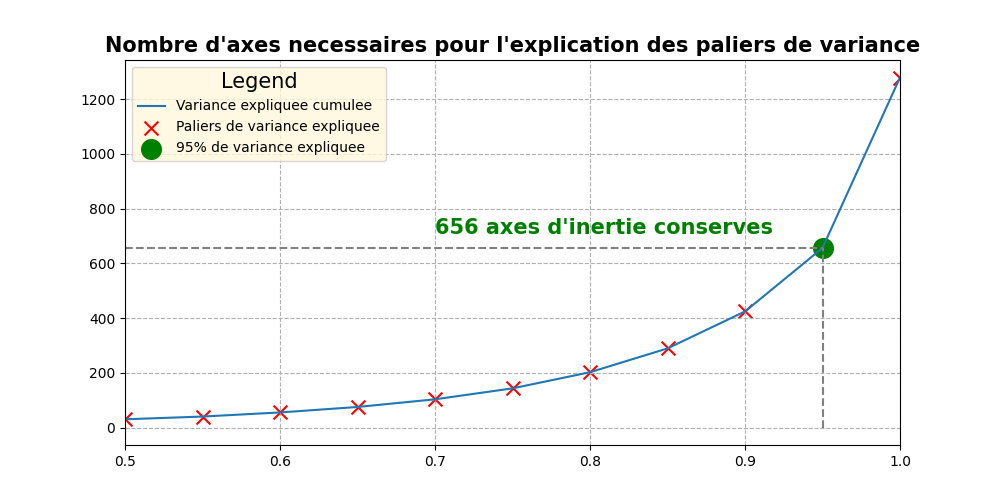

In [39]:
#Visualisation de la variance expliquée par paliées

explained_variancy = [float(x[4:]) for x in init_pandas.index]
num_axis = init_pandas[init_pandas.columns[1]].values

plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size' : 10})
plt.title("Nombre d'axes necessaires pour l'explication des paliers de variance", size = 15, weight = 'bold')
plt.plot(explained_variancy, num_axis, label = 'Variance expliquee cumulee')
plt.scatter(explained_variancy, num_axis, color = 'red', marker = 'x', s = 100, label = 'Paliers de variance expliquee')
plt.scatter([explained_variancy[-2]], [num_axis[-2]], color = 'green', marker = 'o', s = 200, label = '95% de variance expliquee')
plt.xlim(0.5, 1)
plt.grid(True, ls = '--')
plt.legend(loc = 'upper left', title = 'Legend', facecolor = 'cornsilk', title_fontsize = 15)
plt.plot(np.linspace(0.5, 0.95, len(explained_variancy)-1), np.full(len(explained_variancy)-1, num_axis[-2]),
        ls = '--', color = 'grey')
plt.plot(np.full(len(explained_variancy)-1, explained_variancy[-2]), np.linspace(0, num_axis[-2], len(explained_variancy)-1),
        ls = '--', color = 'grey')
plt.text(0.7, num_axis[-2] + 50, "{} axes d'inertie conserves".format(num_axis[-2]), size = 15, weight = 'bold', color = 'green')
plt.show()
%matplot plt

### 5.3- Choix de conserver 95% de la variance expliquée

In [40]:
#Utilisation de la PCA avec 556 features

pca_finale = PCA(k=656, inputCol="features_std", outputCol = "pca_features").fit(spark_features_df)
spark_features_df = pca_finale.transform(spark_features_df)
spark_features_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|                path|         label|            features|    features_vectors|        features_std|        pca_features|
+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.9820566, ...|[0.0,4.9820566177...|[-0.7690936033439...|[-7.0008247257896...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.06933715, 0.44...|[0.06933715194463...|[-0.6363233562448...|[-1.7320604802403...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.33765963, 0.27...|[0.33765962719917...|[-0.1225260579331...|[0.85368665861918...|
|s3://oc-ds8-ye-da...|     Raspberry|[0.012767685, 0.2...|[0.01276768464595...|[-0.7446454020870...|[-2.1255691517141...|
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.363872, 0...|[0.0,4.3638720512...|[-0.7690936033439...|[-7.9225942987067...|
|s3://oc-ds8-ye-da...|  

In [41]:
#Mise en place du dataframe final avec les seuls colonnes intéressantes, et passage du type vecteur au type array

final_df = spark_features_df.select(spark_features_df.pca_features,spark_features_df.label)
final_df = final_df.withColumn("features_vectors", vector_to_array("pca_features"))
final_df = final_df.drop('pca_features')
final_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+--------------------+
|         label|    features_vectors|
+--------------+--------------------+
|Pineapple Mini|[-7.0008247257896...|
|     Raspberry|[-1.7320604802403...|
|     Raspberry|[0.85368665861918...|
|     Raspberry|[-2.1255691517141...|
|Pineapple Mini|[-7.9225942987067...|
+--------------+--------------------+
only showing top 5 rows

In [42]:
#Séparation des features en colonnes différentes 

final_df_split = final_df.select(["label"] + [col("features_vectors")[i] for i in range(556)])
final_df_split_pandas = final_df_split.toPandas()
final_df_split_pandas.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            label  ...  features_vectors[555]
0  Pineapple Mini  ...              -0.218691
1       Raspberry  ...               0.287355
2       Raspberry  ...               0.617439
3       Raspberry  ...               0.178035
4  Pineapple Mini  ...              -0.219639

[5 rows x 557 columns]
/mnt/yarn/usercache/livy/appcache/application_1682462009535_0003/container_1682462009535_0003_01_000001/pyspark.zip/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series

In [43]:
#Affichage du nombre de partitions du dataframe

final_df_split.rdd.getNumPartitions()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3

In [44]:
#Réunification des partitions

final_df_split = final_df_split.repartition(1)
final_df_split.rdd.getNumPartitions()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1

In [46]:
#Enregistrement au format .csv du dataframe

final_df_split.write.mode("overwrite").csv(PATH_PCA_Results_Train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
#Importation des données de test sous la forme d'un dataframe pyspark

test_features_df = pd2.frame.DataFrame.to_spark(pd2.read_parquet(PATH_Result_Test))
test_features_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|s3://oc-ds8-ye-da...|    Watermelon|[0.023526598, 0.0...|
|s3://oc-ds8-ye-da...|    Watermelon|[0.003376022, 0.6...|
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.777818, 0...|
|s3://oc-ds8-ye-da...|Pineapple Mini|[0.0, 4.5876484, ...|
|s3://oc-ds8-ye-da...|    Watermelon|[0.6159177, 0.622...|
+--------------------+--------------+--------------------+
only showing top 5 rows

In [55]:
#Application de la chaîne de traitement au jeu de données de test

test_features_df = test_features_df.withColumn("features_vectors", array_to_vector("features"))
test_features_df = std.transform(test_features_df)
test_features_df = pca.transform(test_features_df)
test_features_df = test_features_df.select(test_features_df.pca_features,test_features_df.label)
test_features_df = test_features_df.withColumn("features_vectors", vector_to_array("pca_features"))
test_features_df = test_features_df.drop('pca_features')
test_features_df = test_features_df.select(["label"] + [col("features_vectors")[i] for i in range(656)]).repartition(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
#Enregistrement au format .csv du dataframe

test_features_df.write.mode("overwrite").csv(PATH_PCA_Results_Test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 6- Scritp d'exécution finale avec l'ensemble de la chaîne de traitement

In [40]:
#Importation des librairies

#Librairies de manipulation des données
import pandas as pd
from PIL import Image
import numpy as np
from time import perf_counter

#Librairies gestion système
import io
import os

#Visualisation des données
import matplotlib.pyplot as plt
%matplot plt

#Manipulation des données via pyspark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

#Modules tensorflow d'extraction des features
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

#Importation du module pandas de pyspark
from pyspark import pandas as pd2

#Gestion des types de données pyspark
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import StructType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import array_to_vector
from pyspark.ml.functions import vector_to_array

#Importation de la PCA pyspark
from pyspark.ml.feature import PCA

#Création du driver et du sparkcontext permettant d'attribuer les différentes tâches à nos executeurs

spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

sc = spark.sparkContext

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
#Défintion des variables importantes pour notre script (possibilité de créer des variables d'environnement pour le 
#script final)

init_path_test = 's3://oc-ds8-ye-data-eu/Test'
end_path_test = 's3://oc-ds8-ye-data-eu/PCA_Results_Test'
init_path_train = 's3://oc-ds8-ye-data-eu/Train'
end_path_train = 's3://oc-ds8-ye-data-eu/PCA_Results_Train'
middle_path_train = 's3://oc-ds8-ye-data-eu/Results_Train'
middle_path_test = 's3://oc-ds8-ye-data-eu/Results_Test'
pca_features = 656
n_partitions = 24
use_intermediate = True

#Création du feature extractor et broadcast des poids du modèle (poids imagenet)

model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

#De manière à obtenir une sortie de forme (1, 1280), nous conservons le modèle jusqu'à la couche de GlobalAvergaePooling

new_model = tf.keras.Model(inputs=model.input,
                  outputs=model.layers[-2].output)
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
#Fonctions provenant du notebook de l'alternant pour l'extraction des features des images

def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1682462009535_0003/container_1682462009535_0003_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

In [60]:
#Fonction d'accès aux données d'images sur le repértoire du bucket S3
def access_data(path):
    images = spark.read.format("binaryFile") \
      .option("pathGlobFilter", "*.jpg") \
      .option("recursiveFileLookup", "true") \
      .load(path)
    images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
    return images

#Extraction des feattures des images à partir du dataframe initial
def perform_extraction(images):
    features_df = images.repartition(n_partitions).select(col("path"), col("label"),featurize_udf("content").alias("features"))
    return features_df

#Fonction d'entraînement du standard scaler et de la pca 
def pca_trainer(df):
    try:
        assert 'label' in df.columns
        assert 'features' in df.columns
    except:
        raise Exception("Columns missing in the DataFrame!")

    df = df.withColumn("features_vectors", array_to_vector("features")).drop('features')
    std = StandardScaler(inputCol = 'features_vectors', outputCol = 'std_features').fit(df)
    pca = PCA(k = pca_features, inputCol = 'std_features', outputCol = 'pca_features').fit(std.transform(df))
    return std, pca

#Fonction d'aplpication de la réduction dimensionnelle
def dimension_reducer(df, std, pca):
    df = df.repartition(n_partitions)
    df = df.withColumn("features_vectors", array_to_vector("features")).drop('features')
    df = std.transform(df).drop('features_vectors')
    df = pca.transform(df).drop('std_features').drop('std_features')
    df = df.withColumn("features", vector_to_array("pca_features")).drop('pca_features')
    df = df.select(["label"] + [col("features")[i] for i in range(pca_features)])
    return df

#Fonction de sauvegarde des données au format .csv
def save_pca_features(df, path):
    df = df.repartition(1)
    df.write.mode("overwrite").csv(path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
#Accès à la base de données d'images
t1 = perf_counter()
images_test = access_data(init_path_test)
test_access_time = perf_counter() - t1

t2 = perf_counter()
images_train = access_data(init_path_train)
train_access_time = perf_counter() - t2

print("Temps d'acces aux donnees d'entrainement : {:.2f} secondes".format(train_access_time))
print("Temps d'acces aux donnees de test : {:.2f} secondes".format(test_access_time))
print('\n')

#Extraction des features des images du jeu de données de test
t3 = perf_counter()
df_test = perform_extraction(images_test)
test_extraction_time = perf_counter() - t3

#Extraction des features des images du jeu de données d'entraînement
t4 = perf_counter()
df_train = perform_extraction(images_train)
train_extraction_time = perf_counter() - t4
print("Temps d'extraction des features du jeu de donnees d'entrainement : {:.2f} secondes".format(train_extraction_time))
print("Temps d'extraction des features du jeu de donnees test : {:.2f} secondes".format(test_extraction_time))
print('\n')

#Lecture des données extraites pour gain de temps 
if use_intermediate == True:
    try:
        df_train = spark.read.parquet(middle_path_train).repartition(24)
        df_test = spark.read.parquet(middle_path_test).repartition(24)
    except:
        df_train.write.mode("overwrite").csv(middle_path_train)
        df_test.write.mode("overwrite").csv(middle_path_test)
        df_train = spark.read.parquet(middle_path_train).repartition(24)
        df_test = spark.read.parquet(middle_path_test).repartition(24)
else:
    pass

#Entraînement PCA sur jeu de données d'entraînement
t5 = perf_counter()
std, pca = pca_trainer(df_train)
pca_train_time = perf_counter() - t5
print("Temps d'entrainement de la PCA et du preprocesseur : {:.2f} secondes".format(pca_train_time))
print('\n')

#Réduction de dimension train
t6 = perf_counter()
df_train = dimension_reducer(df_train, std, pca)
train_reduction_time = perf_counter() - t6

#Réduction de dimension test
t7 = perf_counter()
df_test = dimension_reducer(df_test, std, pca)
test_reduction_time = perf_counter() - t7

print("Temps de reduction de dimensions du jeu de donnees d'entrainement : {:.2f} secondes".format(train_reduction_time))
print("Temps de reduction de dimensions du jeu de donnees test : {:.2f} secondes".format(test_reduction_time))
print('\n')

#Sauvegarde des données après réduction de dimension sur l ebucket s3
save_pca_features(df_test, end_path_test)
save_pca_features(df_train, end_path_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Temps d'acces aux donnees d'entrainement : 6.80 secondes
Temps d'acces aux donnees de test : 11.32 secondes


Temps d'extraction des features du jeu de donnees d'entrainement : 0.01 secondes
Temps d'extraction des features du jeu de donnees test : 0.09 secondes


Temps d'entrainement de la PCA et du preprocesseur : 67.63 secondes


Temps de reduction de dimensions du jeu de donnees d'entrainement : 1.19 secondes
Temps de reduction de dimensions du jeu de donnees test : 1.34 secondes

In [90]:
#Regroupement des temps de traitements

times = [test_access_time, train_access_time, test_extraction_time, train_extraction_time, pca_train_time, train_reduction_time, test_reduction_time]
labels = ['test_access_time', 'train_access_time', 'test_extraction_time', 'train_extraction_time', 'pca_train_time', 'train_reduction_time', 'test_reduction_time']
times_df = pd.DataFrame({'times' : times, 'labels' : labels}).sort_values(by = 'times')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

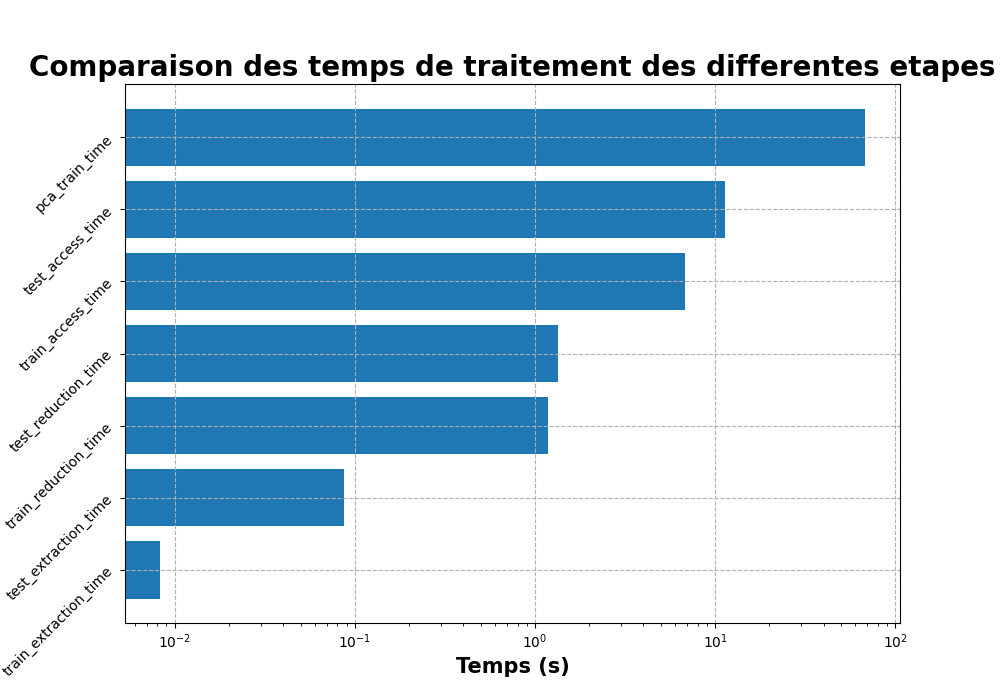

In [91]:
#Comparaison des temps de traitements

fig = plt.figure(figsize = (10,7))
plt.rcParams.update({'font.size' : 10})
plt.title("Comparaison des temps de traitement des differentes etapes", size = 20, weight = 'bold')
plt.barh(y = times_df.labels, width = times_df.times)
plt.xscale('log')
plt.xlabel("Temps (s)", size = 15, weight = 'bold')
plt.ylabel("Steps", size = 15, weight = 'bold')
y = plt.yticks(rotation = 45)
plt.grid(True, ls = '--')
plt.show()
%matplot plt